In [ ]:
#!pip install xgboost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Question
Can I predict the impact_sa and find out which features have the most influence on it?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import plotly.express as px

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Mini Company - FR Corp/1.Projects/Music/4.Modeling Experiments/New Data/sub_1_pod_symmetry_per_step.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Mini Company - FR Corp/1.Projects/Music/4.Modeling Experiments/New Data/sub_2_pod_symmetry_per_step.csv')

In [ ]:
df1 = df1.drop(columns=['bout_idx','impact_left','impact_right'], axis=1)
df2 = df2.drop(columns=['bout_idx','impact_left','impact_right'], axis=1)

In [ ]:
fig = px.histogram(df1['impact_sa'])
fig

In [ ]:
print(df2['impact_sa'].describe())
print("The Median is: "+ str(df1['impact_sa'].median()))

count    16161.000000
mean        -0.049720
std          0.060877
min         -0.242238
25%         -0.090931
50%         -0.052494
75%         -0.011744
max          0.173803
Name: impact_sa, dtype: float64
The Median is: -0.018184189351296957


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
X2 = df2.iloc[:,:].drop(columns=['impact_sa', 't', 'initial_foot',  'track_uri', 'session_id'])
y2 = df2['impact_sa']

In [ ]:
data_dmatrix = xgb.DMatrix(data=X2, label=y2)

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=123)

# XGB Cross Validation testperson 2

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
classifier = xgb.XGBRegressor()
regressor = xgb.XGBRegressor()

In [ ]:
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]

In [ ]:
## Hyper Parameter Optimization
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [ ]:
# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'r2',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [ ]:
random_cv.fit(X2_train,y2_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[15:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True, scoring='r2',
                   verbose=5)

In [ ]:
r2_preds = random_cv.predict(X2_test)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(X2_train,y2_train)

preds = xg_reg.predict(X2_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y2_test, r2_preds))
print("RMSE: %f" % (rmse))

RMSE: 0.011676


# XGB Boosting

In [ ]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 10, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [ ]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.498576,0.000259,0.498575,0.000605
1,0.449599,0.000232,0.449599,0.000630
2,0.405536,0.000255,0.405526,0.000606
3,0.365977,0.000197,0.365978,0.000645
4,0.330392,0.000179,0.330373,0.000686


In [ ]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.035796
Name: test-rmse-mean, dtype: float64


In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(X2_train, y2_train)

XGBRegressor(alpha=10, colsample_bytree=0.3, max_depth=5, n_estimators=10,
             objective='reg:squarederror')

In [ ]:
preds = xg_reg.predict(X2_test)

# Results

In [ ]:
df2['impact_sa'].describe()

count    16161.000000
mean        -0.049720
std          0.060877
min         -0.242238
25%         -0.090931
50%         -0.052494
75%         -0.011744
max          0.173803
Name: impact_sa, dtype: float64

In [ ]:
from sklearn.metrics import r2_score

r2_score(y2_test, preds)

-9.200746028825314

In [ ]:
rmse = np.sqrt(mean_squared_error(y2_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.196449


# Visualizing the XGB Tree & Feature analysis

In [ ]:
#!pip install graphviz

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

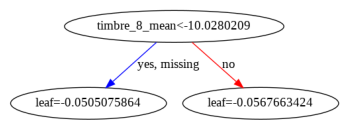

In [ ]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

In [1]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [8, 8]
plt.show()

NameError: ignored